In [1]:
import h5py
import numpy as np
from matplotlib.pyplot import *

In [2]:
def print_attrs(name, obj):
    print(name)
    try:
        for key, val in obj.items():
            print("\t{:s}: {:s}".format(str(key), str(val)))
    except:
        pass
    
def dump_h5(fname):
    with h5py.File(fname) as fid:
        fid.visititems(print_attrs)

In [3]:
dump_h5('./550758_trimmed.h5')

file_info
	format_type: <HDF5 dataset "format_type": shape (1,), type "|S16">
	run_number_list: <HDF5 dataset "run_number_list": shape (1,), type "<i8">
	version: <HDF5 dataset "version": shape (1,), type "|S7">
file_info/format_type
file_info/run_number_list
file_info/version
run_550758
	detector_2d_1: <HDF5 group "/run_550758/detector_2d_1" (51 members)>
	detector_2d_2: <HDF5 group "/run_550758/detector_2d_2" (51 members)>
	event_info: <HDF5 group "/run_550758/event_info" (3 members)>
	exp_info: <HDF5 group "/run_550758/exp_info" (1 members)>
	run_info: <HDF5 group "/run_550758/run_info" (4 members)>
run_550758/detector_2d_1
	detector_info: <HDF5 group "/run_550758/detector_2d_1/detector_info" (10 members)>
	tag_661612304: <HDF5 group "/run_550758/detector_2d_1/tag_661612304" (1 members)>
	tag_661612306: <HDF5 group "/run_550758/detector_2d_1/tag_661612306" (1 members)>
	tag_661612308: <HDF5 group "/run_550758/detector_2d_1/tag_661612308" (1 members)>
	tag_661612310: <HDF5 group "/ru

	tag_661612322: <HDF5 group "/run_550758/detector_2d_2/tag_661612322" (1 members)>
	tag_661612324: <HDF5 group "/run_550758/detector_2d_2/tag_661612324" (1 members)>
	tag_661612326: <HDF5 group "/run_550758/detector_2d_2/tag_661612326" (1 members)>
	tag_661612328: <HDF5 group "/run_550758/detector_2d_2/tag_661612328" (1 members)>
	tag_661612330: <HDF5 group "/run_550758/detector_2d_2/tag_661612330" (1 members)>
	tag_661612332: <HDF5 group "/run_550758/detector_2d_2/tag_661612332" (1 members)>
	tag_661612334: <HDF5 group "/run_550758/detector_2d_2/tag_661612334" (1 members)>
	tag_661612336: <HDF5 group "/run_550758/detector_2d_2/tag_661612336" (1 members)>
	tag_661612338: <HDF5 group "/run_550758/detector_2d_2/tag_661612338" (1 members)>
	tag_661612340: <HDF5 group "/run_550758/detector_2d_2/tag_661612340" (1 members)>
	tag_661612342: <HDF5 group "/run_550758/detector_2d_2/tag_661612342" (1 members)>
	tag_661612344: <HDF5 group "/run_550758/detector_2d_2/tag_661612344" (1 members)>
	tag

	electron_energy_in_eV: <HDF5 dataset "electron_energy_in_eV": shape (), type "<f8">
	k_parameter: <HDF5 dataset "k_parameter": shape (), type "<f8">
	photon_energy_in_eV: <HDF5 dataset "photon_energy_in_eV": shape (), type "<f8">
run_550758/run_info/sacla_config/electron_energy_in_eV
run_550758/run_info/sacla_config/k_parameter
run_550758/run_info/sacla_config/photon_energy_in_eV
run_550758/run_info/start_tag_number


In [8]:
def get_run_list(fid):
    return list(fid['file_info/run_number_list'])
    
def get_tag_list(fid, run):
    return list(fid['run_{:d}/event_info/tag_number_list'.format(run)])

def get_2d_detector_list(fid, run):
    return list(fid['run_{:d}/run_info/detector_config/detector_2d_list'.format(run)])

def get_images(fid):
    runs = get_run_list(fid)
    data = {}
    for run in runs:
        tags = get_tag_list(fid, run)
        dets = get_2d_detector_list(fid, run)
        images = {}
        for det in dets:
            shape = np.array(fid['run_{:d}/detector_2d_{:d}/tag_{:d}/detector_data'.format(run,det,tags[0])]).shape
            dtype = np.array(fid['run_{:d}/detector_2d_{:d}/tag_{:d}/detector_data'.format(run,det,tags[0])]).dtype
            images['{:d}'.format(det)] = (np.empty([len(tags)] + list(shape),dtype=dtype))
            for k,tag in enumerate(tags):
                images['{:d}'.format(det)][k,:,:] = np.array(fid['run_{:d}/detector_2d_{:d}/tag_{:d}/detector_data'.format(run,det,tag)])
        data['{:d}'.format(run)] = images
    return data

In [5]:
with h5py.File('./550758_trimmed.h5','r') as fid:
    data = get_images(fid)

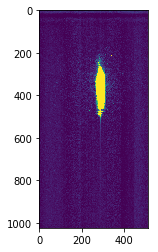

In [9]:
img = data['550758']['1'].mean(axis=0)
vmin, vmax = np.percentile(np.ravel(img), [1, 99])
imshow(data['550758']['2'].mean(axis=0), vmin=vmin, vmax=vmax)

In [45]:
def write_data(fname, dict_data):
    """
    
    :param fname: file name to write out to
    :param dict_data: a dictionary containing data.
    :return: nothing
    
    dict_data is expected to be of the form:
        <level 1> string id:
            <level 2> string id: data
            <level 2> string id: data
                
    This function will over-write any data found in the file
    that has a matching <level 1>/<level 2> group name
    """
    with h5py.File(fname, 'a') as fid:
        for key,val in dict_data.items():
            path = descend(fid, '', key)
            for key2,val2 in val.items():
                dname = path + '/{:s}'.format(key2)
                fid.require_dataset(dname, shape=val2.shape, dtype=val2.dtype)
                fid[dname][...] = val2
            
def descend(fid, path, key):
    path = path + '{:s}'.format(key)
    fid.require_group(path)
    return path

In [47]:
write_data('./550758_repacked.h5', data)

In [48]:
dump_h5('./550758_repacked.h5')

550758
	1: <HDF5 dataset "1": shape (50, 1024, 512), type "<f4">
	2: <HDF5 dataset "2": shape (50, 1024, 512), type "<f4">
550758/1
550758/2


In [4]:
dump_h5('./550758_imgavg.h5')

file_info
	format_type: <HDF5 dataset "format_type": shape (1,), type "|S16">
	run_number_list: <HDF5 dataset "run_number_list": shape (1,), type "<i8">
	version: <HDF5 dataset "version": shape (1,), type "|S5">
file_info/format_type
file_info/run_number_list
file_info/version
run_0
	detector_2d_1: <HDF5 group "/run_0/detector_2d_1" (2 members)>
	detector_2d_2: <HDF5 group "/run_0/detector_2d_2" (2 members)>
	event_info: <HDF5 group "/run_0/event_info" (1 members)>
	exp_info: <HDF5 group "/run_0/exp_info" (1 members)>
	run_info: <HDF5 group "/run_0/run_info" (3 members)>
run_0/detector_2d_1
	detector_info: <HDF5 group "/run_0/detector_2d_1/detector_info" (1 members)>
	tag_0: <HDF5 group "/run_0/detector_2d_1/tag_0" (1 members)>
run_0/detector_2d_1/detector_info
	detector_name: <HDF5 dataset "detector_name": shape (1,), type "|S18">
run_0/detector_2d_1/detector_info/detector_name
run_0/detector_2d_1/tag_0
	detector_data: <HDF5 dataset "detector_data": shape (1024, 512), type "<f4">
run_

In [9]:
with h5py.File('550758_imgavg.h5') as fid:
    data = get_images(fid)

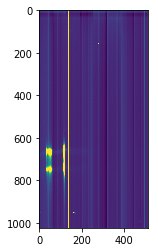

In [20]:
img = data['0']['1'].squeeze()
vmin, vmax = np.percentile(np.ravel(img), [1, 99])
imshow(img,vmin=vmin, vmax=vmax)